<a href="https://colab.research.google.com/github/geunsoo-kim/pytorch_deeplearning/blob/main/Animal10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch import nn, optim

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"geunsookim","key":"0a29ac4b22e39e374ed97698fff0e124"}'}

In [ ]:
import os
import shutil

os.makedirs('/root/.kaggle',exist_ok=True)
path=os.getcwd()

print(path)
#파일을 복사하는 데, 이미 복사된 경우 복사하지 않는다.
if not os.path.exists(os.path.join('/root/.kaggle/','kaggle.json')):
     src=os.path.join(path,'kaggle.json')
     print(src)
     dst=os.path.join('/root/.kaggle/', 'kaggle.json')
     print(dst)
     shutil.copyfile(src,dst)
     print('파일 복사 완료')

/content
/content/kaggle.json
/root/.kaggle/kaggle.json
파일 복사 완료


In [ ]:
!ls -al /root/.kaggle

total 16
drwxr-xr-x 2 root root 4096 Oct  2 00:08 .
drwx------ 1 root root 4096 Oct  2 00:08 ..
-rw-r--r-- 1 root root   66 Oct  2 00:08 kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 99% 577M/586M [00:06<00:00, 82.8MB/s]
100% 586M/586M [00:06<00:00, 90.2MB/s]


In [ ]:
!unzip -qq animals10.zip -d ./data

In [ ]:
from torchvision import transforms
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(root='/content/data/raw-img', transform=manual_transform)

In [ ]:
from torch.utils.data import random_split
train_size=int(0.8*len(dataset))
test_valid_size=int(len(dataset)-train_size)
train_dataset,valid_dataset=torch.utils.data.random_split(dataset,[train_size,test_valid_size])

valid_size=int(0.5*len(valid_dataset))
test_size=int(len(valid_dataset)-valid_size)
valid_dataset,test_dataset=torch.utils.data.random_split(valid_dataset,[valid_size,test_size])

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

20943
2618
2618


In [ ]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
model=torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 12.4MB/s]


In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)

val_loader = DataLoader(valid_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False,
                       num_workers=2)

len(train_loader), len(test_loader), len(val_loader)

(655, 82, 82)

In [ ]:
class_names = dataset.classes
print(dataset.classes)
new_class_names=['dog','horse','elephant','butterfly','chicken','cat','cow','sheep','spider','squirrel']
class_names=new_class_names
class_names

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

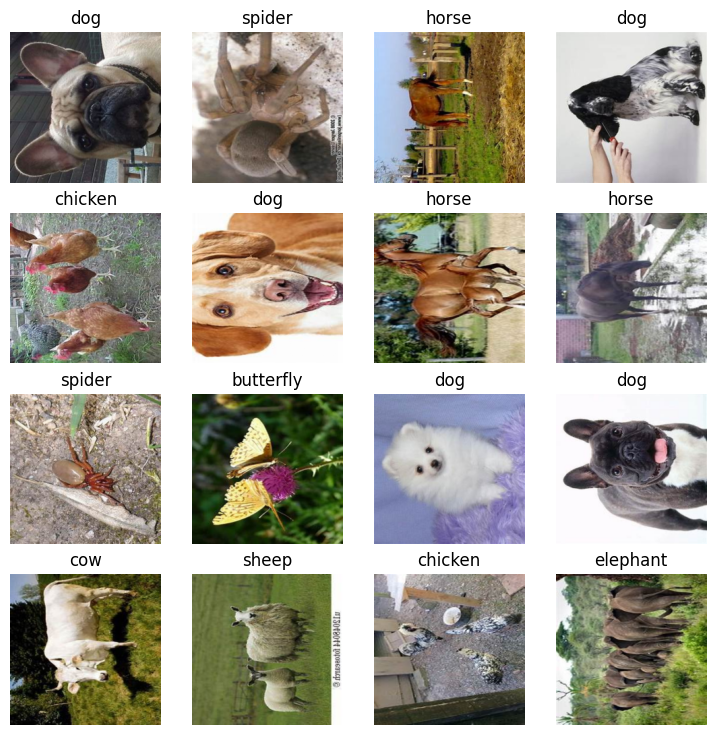

In [ ]:
import matplotlib.pyplot as plt

# torch.manual_seed()
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(2, 1, 0))
    plt.title(class_names[label])
    plt.axis(False);

In [ ]:
for param in model.features.parameters():#model.feature부분 파라미터 수정하지 않는다.
    param.requires_grad = False

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
try:
    from going_modular.going_modular import data_setup, engine
except:
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 20.93 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_loader,
                       test_dataloader=val_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2117 | train_acc: 0.9380 | test_loss: 0.1697 | test_acc: 0.9515
Epoch: 2 | train_loss: 0.2127 | train_acc: 0.9345 | test_loss: 0.1573 | test_acc: 0.9550
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9355 | test_loss: 0.1501 | test_acc: 0.9550
Epoch: 4 | train_loss: 0.1924 | train_acc: 0.9383 | test_loss: 0.1457 | test_acc: 0.9562
Epoch: 5 | train_loss: 0.1935 | train_acc: 0.9391 | test_loss: 0.1539 | test_acc: 0.9520
[INFO] Total training time: 13058.261 seconds


In [ ]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
#여기부터 하면됨
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")


In [ ]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]